# Project 3

## Load data sets and packages

In [15]:
# Import libraries and functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.model_selection import KFold

# Import data sets
MNIST = pd.read_csv('Numbers.txt', sep=r'\s+')
CATSDOGS = pd.read_csv('catdogdata.txt', sep=r'\s+')

## Workflow

Cluster methods:
- K-Means
- GMM

Double cross-validation
- Outer loop: For determining stability
- Inner loop: Tune pre-processing threshold and number of clusters

## Load data and transform data

In [16]:
# Seperate labels from data
MNIST_labels = MNIST["V1"].values
MNIST_pixels = MNIST.iloc[:, 1:].values
CATSDOGS_labels = ["Cat"]*99 + ["Dog"]*99
CATSDOGS_pixels = CATSDOGS.iloc[:, :].values

# Standardize data
MNIST_scaler = MinMaxScaler()
MNIST_pixels = MNIST_scaler.fit_transform(MNIST_pixels)
CATSDOGS_scaler = MinMaxScaler()
CATSDOGS_pixels = CATSDOGS_scaler.fit_transform(CATSDOGS_pixels)

In [18]:
import warnings
warnings.filterwarnings(
    "ignore",
    message="'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.",
    category=FutureWarning,
    module="sklearn"
)

## MNIST: K-Means

In [ ]:
# Number of clusters in K-Means
k_list = np.arange(3, 20)

# UMAP 
comp_list = [2, 5, 10, 15, 20]

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store silhouette scores and best k:s
outer_silhouette_scores = []
outer_best_config = []

# For each outer fold
for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(MNIST_pixels)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    outer_train = MNIST_pixels[outer_train_index]
    outer_test = MNIST_pixels[outer_test_index]

    # Inner fold - For tuning (number of clusters and PCA variance threshold)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores 
    best_config = {}

    # Keeps track of best result found
    best_inner_score = -1

    # For each PCA variance threshold
    for comp in comp_list:

        # UMAP filtering
        umap = UMAP(n_components=comp)
        outer_train_umap = umap.fit_transform(outer_train)

        # For each number of cluster
        for k in k_list:

            fold_scores = []

            # For each inner fold
            for j, (inner_train_index, inner_test_index) in enumerate(
                inner_k_fold.split(outer_train_umap)):

                # Divide into test and train data
                inner_train = outer_train_umap[inner_train_index]
                inner_test = outer_train_umap[inner_test_index]

                # K-Means 
                kmeans = KMeans(
                    n_clusters=k, init='k-means++', n_init='auto'
                )
                kmeans.fit(inner_train)
                cluster_labels = kmeans.predict(inner_test)

                # Calculate silhoutte score
                sil_score = silhouette_score(inner_test, cluster_labels)
                fold_scores.append(sil_score)

            # Store best result
            mean_score = np.mean(fold_scores)
            if mean_score > best_inner_score:
                best_inner_score = mean_score
                best_config = {
                    "n_components": comp,
                    "n_clusters": k
                }

    # Train final model on entire outer training set with best config
    umap = UMAP(n_components=best_config["n_components"])
    outer_train_umap = umap.fit_transform(outer_train)
    outer_test_umap = umap.transform(outer_test)

    # K-Means again
    kmeans = KMeans(
        n_clusters=best_config["n_clusters"], init='k-means++', n_init='auto'
    )
    kmeans.fit(outer_train_umap)
    cluster_labels = kmeans.predict(outer_test_umap)

    # Calculate silhoutte score on test data
    outer_score = silhouette_score(outer_test_umap, cluster_labels)
    outer_silhouette_scores.append(outer_score)
    outer_best_config.append(best_config)

    # Print best config
    print("Best number of UMAP components: " + str(best_config["n_components"]))
    print("Best number of clusters: " + str(best_config["n_clusters"]))
    print("Silhouette score on test data: " + str(round(outer_score, 2)))

    # Print out confusion matrix
    true_labels = MNIST_labels[outer_test_index]
    cluster_label_matrix = pd.crosstab(
        cluster_labels,
        true_labels,
        rownames=['Cluster'], colnames=['True Label']
    )
    print(cluster_label_matrix)

    # Plot silhouette scores
    sample_outer_score = silhouette_samples(outer_test_umap, cluster_labels)
    y_lower = 10
    plt.figure(figsize=(5, 5))
    for cluster in np.unique(cluster_labels):
        ith_cluster_sil_values = sample_outer_score[cluster_labels == cluster]
        ith_cluster_sil_values.sort()
        size_cluster = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster, str(cluster))
        y_lower = y_upper + 10

    plt.title("Silhouette plot")
    plt.xlabel("Silhouette coefficient values")
    plt.ylabel("Cluster label")
    plt.yticks([])
    plt.axvline(x=outer_score, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()

# Print out some final statistics
all_k = [conf["n_clusters"] for conf in outer_best_config]
all_umap = [conf["n_components"] for conf in outer_best_config]

print("Average silhouette score: " + str(round(np.mean(outer_silhouette_scores), 2)))
print("Mean number of clusters: " + str(round(np.mean(all_k), 2)))
print("Std of number of clusters: " + str(round(np.std(all_k), 2)))
print("Mean number of UMAP components: " + str(round(np.mean(all_umap), 2)))
print("Std of UMAP components: " + str(round(np.std(all_umap), 2)))

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3255957485.py, line 137)

## Perform PCA

In [8]:
# PCA with variance threshold 60%
variance_threshold = 0.5

# MNIST
MNIST_PCA = PCA(n_components=variance_threshold)
MNIST_pixels_PCA = MNIST_PCA.fit_transform(MNIST_pixels)
MNIST_number_of_components = MNIST_PCA.n_components_
print("MNIST number of principal components: " + str(MNIST_number_of_components))

# Cats and Dogs
CATSDOGS_PCA = PCA(n_components=variance_threshold)
CATSDOGS_pixels_PCA = CATSDOGS_PCA.fit_transform(CATSDOGS_pixels)
CATSDOGS_number_of_components = CATSDOGS_PCA.n_components_
print("Cats and Dogs number of principal components: " + str(CATSDOGS_number_of_components))

MNIST number of principal components: 7
Cats and Dogs number of principal components: 4


## MNIST: K-Means tuning with silhouette score


Outer fold: 1
Best k: 8
Mean silhouette score: 0.29
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            3   0  34   0   1   1   6   0   0
1            1   1   0   0   3   1   0  27  30
2            1   0   0  61   0   0   0   0   1
3            0  30   0   0   0   6   0   0   0
4            1   1   0   0  39   0   5   1   0
5            0   5   2   0   5  21   1   8   1
6            0   1  25   0   1   2   0   0   0
7           27   0   4   0   1   3  39   0   0


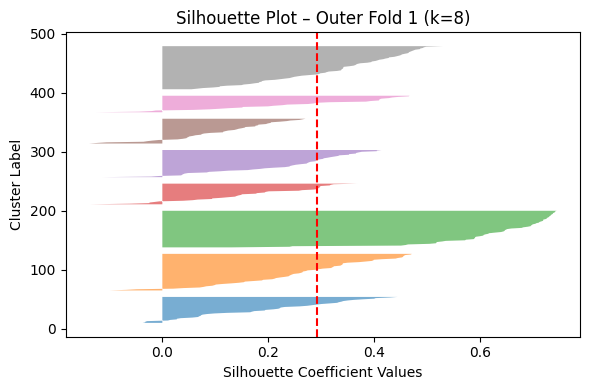


Outer fold: 2
Best k: 7
Mean silhouette score: 0.28
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0  39   1   0   0   7   0   1   0
1            0   0  34   0   0   6   1   0   0
2            1   0   0  63   0   0   0   0   1
3            0   9   1   0   4  10   0  30  30
4            4   0  25   0   1   8  13   0   0
5           34   1   7   0   4  11  20   0   0
6            0   1   0   0  31   0   0   2   0


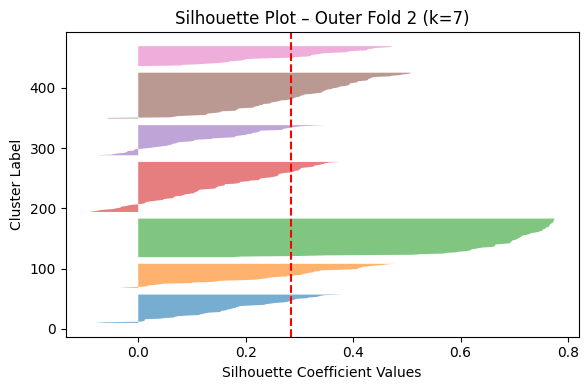


Outer fold: 3
Best k: 8
Mean silhouette score: 0.29
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0   0   2   0  31   1   4   3   0
1            1   0  33   0   1   1  10   1   1
2            0   8   0   0   4  29   0  23   2
3            0   0  32   0   1   2   3   1   0
4           27   0   3   0   2   3  22   0   0
5            0  22   0   0   1   5   0   1   0
6            1   0   0  60   0   0   3   0   0
7            1   3   1   0   1   1   0   6  43


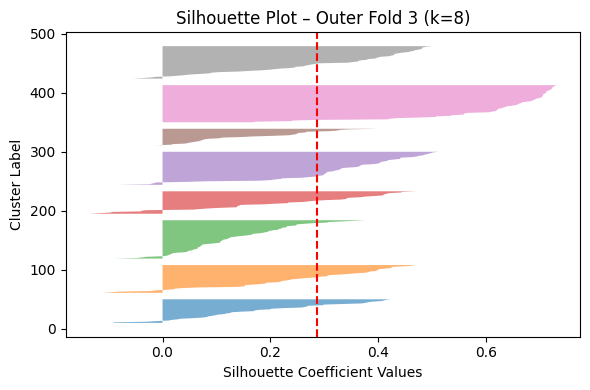


Outer fold: 4
Best k: 8
Mean silhouette score: 0.28
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0           41   1   4   0   4   2  23   1   0
1            0  37   1   0   0   4   0   0   1
2            1   5   2   0   3  24   0  11   0
3            2   0   0  58   0   0   0   2   0
4            0   3   0   0   2   2   0  10  33
5            0   1  31   0   0   2   1   1   0
6            4   1  29   0   0   4   8   0   1
7            0   1   0   0  31   1   4   3   0


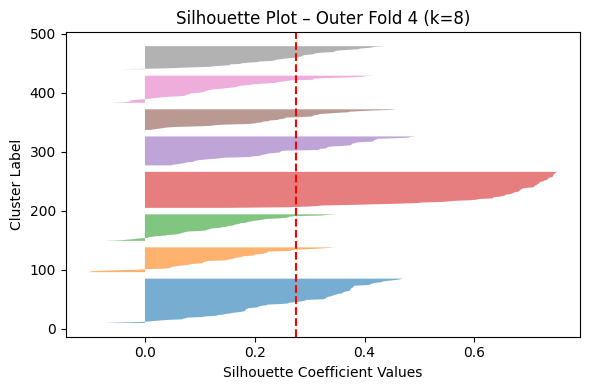


Outer fold: 5
Best k: 9
Mean silhouette score: 0.29
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            1   2   2   0  23   0   4   0   0
1            0   4   0   0   5   3   0  28   0
2            0  36   1   0   0   1   0   0   0
3            0   1  29   0   0   1   3   1   0
4            0   1   0  65   0   0   0   1   1
5           34   0   6   0   1   3  23   0   0
6            0   4   5   0   0  21   3   3   1
7            0   2   1   0   0   0   0   3  33
8            4   1  34   0   0   0   5   0   0


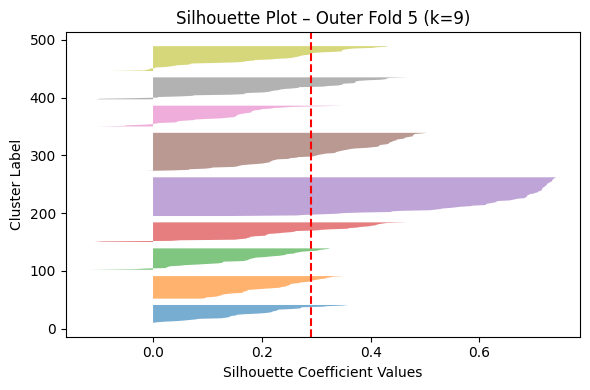


Silhouette Score mean over outer folds: 0.29
Silhouette Score std across outer folds: 0.01
Best k mean over outer folds: 8.0
Best k std over outer folds: 0.63


In [ ]:
# Number of clusters in K-Means
k_list = range(3, 20)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store silhouette scores and best k:s
outer_silhouette_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(MNIST_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    MNIST_pixels_train = MNIST_pixels_PCA[outer_train_index]
    MNIST_pixels_test = MNIST_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores scores for each k
    k_metrics = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
        inner_k_fold.split(MNIST_pixels_train):

        # Divide into test and train data
        inner_train = MNIST_pixels_train[inner_train_index]
        inner_val = MNIST_pixels_train[inner_val_index]

        # Perform K-Means clustering for each k
        for k in k_list:

            # K-Means 
            kmeans = KMeans(
                n_clusters=k, init='k-means++', random_state=0, n_init='auto'
            )
            kmeans.fit(inner_train)

            cluster_labels = kmeans.predict(inner_val)
            sil_score = silhouette_score(inner_val, cluster_labels)
            k_metrics[k].append(sil_score)

    # Calculate average silhouette scores for each k
    avg_scores = {k: np.mean(scores) for k, scores in k_metrics.items()}

    # Calculate best k
    best_k = max(avg_scores, key=avg_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate siluates on test data
    final_kmeans = KMeans(n_clusters=best_k, random_state=0, n_init=10)
    final_kmeans.fit(MNIST_pixels_train)
    final_labels = final_kmeans.predict(MNIST_pixels_test)
    outer_sil = silhouette_score(MNIST_pixels_test, final_labels)
    outer_silhouette_scores.append(outer_sil)
    print("Mean silhouette score: " + str(round(outer_sil, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels = MNIST_labels[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels,  # predicted clusters
        true_labels,   # true MNIST labels
        rownames=['Cluster'], colnames=['True Label']
    )

    print("Confusion matrix:")
    print(cluster_label_matrix)

    # GENERATED WITH CHATGPT
    # Compute silhouette values
    sample_silhouette_values = silhouette_samples(MNIST_pixels_test, final_labels)

    # Create silhouette plot
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for cluster in range(best_k):
        ith_cluster_silhouette_values = sample_silhouette_values[final_labels == cluster]
        ith_cluster_silhouette_values.sort()

        size_cluster = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            alpha=0.6
        )
        y_lower = y_upper + 10

    plt.title(f'Silhouette Plot – Outer Fold {i + 1} (k={best_k})')
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.axvline(x=outer_sil, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()


# Calculate final results and print
mean_outer_silhouette = np.mean(outer_silhouette_scores)
std_outer_silhouette = np.std(outer_silhouette_scores)
mean_outer_k = np.mean(best_k_list)
std_outer_k = np.std(best_k_list)

print("\nSilhouette Score mean over outer folds: " 
      + str(round(mean_outer_silhouette, 2)))
print("Silhouette Score std across outer folds: " 
      + str(round(std_outer_silhouette, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_outer_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_outer_k, 2)))

## MNIST: GMM tuning with BIC

In [5]:
# Number of clusters in GMM
k_list = range(3, 20)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store bic scores and best k:s
outer_bic_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(MNIST_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    MNIST_pixels_train = MNIST_pixels_PCA[outer_train_index]
    MNIST_pixels_test = MNIST_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores for each k
    bic_scores_per_k = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
            inner_k_fold.split(MNIST_pixels_train):
        
        # Divide into test and train data
        inner_train = MNIST_pixels_train[inner_train_index]
        inner_val = MNIST_pixels_train[inner_val_index]

        # Perform GMM clustering for each k
        for k in k_list:
            gmm = GaussianMixture(n_components=k, covariance_type='full')
            gmm.fit(inner_train)
            bic = gmm.bic(inner_val)
            bic_scores_per_k[k].append(bic)

    # Calculate average BIC scores for each k
    avg_bic_scores = {k: np.mean(scores) for k, scores in bic_scores_per_k.items()}

    # Calculate best k
    best_k = min(avg_bic_scores, key=avg_bic_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate BIC on test data
    final_gmm = GaussianMixture(n_components=best_k, covariance_type='full')
    final_gmm.fit(MNIST_pixels_train)
    final_labels = final_gmm.predict(MNIST_pixels_test)
    final_bic = final_gmm.bic(MNIST_pixels_test)
    outer_bic_scores.append(final_bic)
    print("BIC on outer test set: " + str(round(final_bic, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels = MNIST_labels[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels, true_labels,
        rownames=['Cluster'], colnames=['True Label']
    )
    print("Confusion matrix:")
    print(cluster_label_matrix)

# Calculate final results and print
mean_outer_bic = np.mean(outer_bic_scores)
std_outer_bic = np.std(outer_bic_scores)
mean_best_k = np.mean(best_k_list)
std_best_k = np.std(best_k_list)

print("\nBIC mean over outer folds: " 
      + str(round(mean_outer_bic, 2)))
print("BIC std across outer folds: " 
      + str(round(std_outer_bic, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_best_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_best_k, 2)))



Outer fold: 1
Best k: 4
BIC on outer test set: 8712.95
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            2   7  51   0  10  21   8   5   1
1           29   0  13   0   0   6  42   0   0
2            0   0   0  59   0   0   0   0   0
3            2  31   1   2  40   7   1  31  31

Outer fold: 2
Best k: 4
BIC on outer test set: 8608.51
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0           39   1  13   1   1   4  27   0   0
1            0   0   0  60   0   0   0   0   0
2            0  41   1   2  33   6   0  30  31
3            0   8  54   0   6  32   7   3   0

Outer fold: 3
Best k: 4
BIC on outer test set: 8765.1
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0           29   0  14   0   1   2  29   1   0
1            1   4  56   0   5  31  12   3   1
2            0  29   1   3 

## MNIST: Agglomerative Clustering tuning with silhouette score


Outer fold: 1
Best k: 8
Mean silhouette score: 0.25
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0   2   0   0   6   2   0  29  31
1            0   0  25   0   5   2   4   0   0
2            0  32   1   0   0  27   0   4   1
3           19   2   1   0   6   2  17   1   0
4            1   1   0   0  33   0   5   2   0
5           13   0  15   0   0   1  25   0   0
6            0   1  23   0   0   0   0   0   0
7            0   0   0  61   0   0   0   0   0


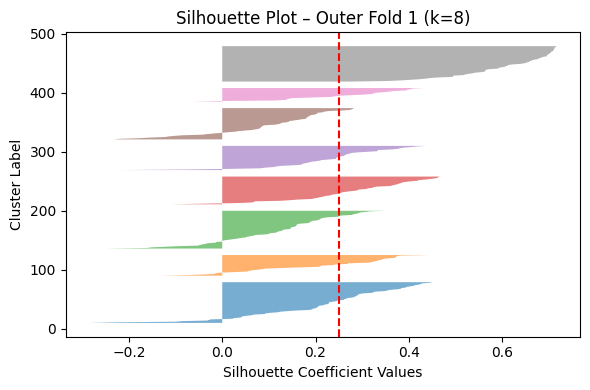


Outer fold: 2
Best k: 10
Mean silhouette score: 0.25
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0   3   0   0   0  21   0  16   0
1            9   1  22   0   0   0  22   0   0
2            1  24   1   0  18  14   3  11   7
3            0   0   0  62   0   0   0   0   0
4            0   0  20   0   0   0   0   0   0
5            0   0   2   0  20   0   0   2   0
6           29   0   1   1   2   1   8   0   0
7            0  21   2   0   0   4   0   1   0
8            0   1   0   0   0   1   0   3  24
9            0   0  20   0   0   1   1   0   0


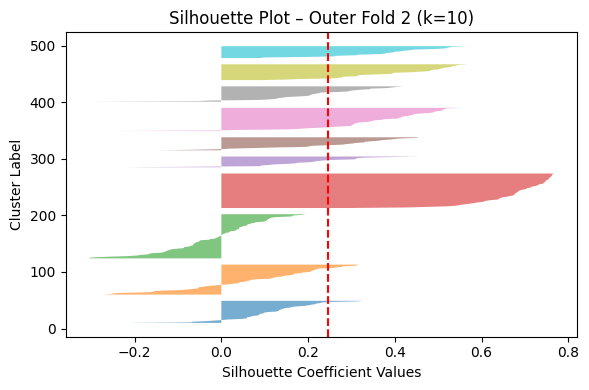


Outer fold: 3
Best k: 9
Mean silhouette score: 0.26
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0   0  38   0   1   4  13   0   0
1            0   0  26   0   2   1   2   1   0
2            0  23   0   0   2   3   0   1   0
3            3   1   3   0   2  25   5   1   2
4            0   7   0   0   4   6   0  21   0
5            0   0   0   0   0   1   0   1  44
6            1   0   0  60   0   0   1   0   0
7           25   1   3   0   2   1  21   0   0
8            1   1   1   0  28   1   0  10   0


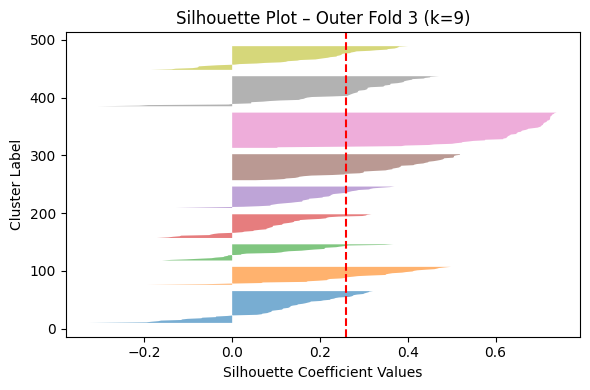


Outer fold: 4
Best k: 8
Mean silhouette score: 0.25
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            1   1  46   0   0   2   2   1   0
1           43   1  14   0   2   1  28   0   0
2            0  32   0   0   7   2   1   0   1
3            0   6   0   0   4   8   0  23   1
4            2   8   7   0   0  25   4   0   5
5            2   0   0  58   0   0   1   0   0
6            0   1   0   0  27   0   0   3   0
7            0   0   0   0   0   1   0   1  28


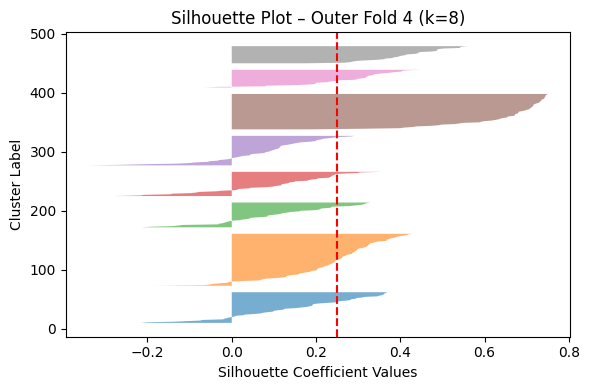


Outer fold: 5
Best k: 8
Mean silhouette score: 0.26
Confusion matrix:
True Label  -9  -2   0   1   2   5   6   8   9
Cluster                                       
0            0   1  40   0   1   4  12   1   0
1            0   7   0   0   3   3   0  28  28
2            7   3   9   0   0  21   9   3   1
3            1   0   0  65   0   0   0   1   1
4           30   0   4   0   1   0  17   0   0
5            0  37   0   0   0   1   0   1   5
6            1   3   0   0  24   0   0   2   0
7            0   0  25   0   0   0   0   0   0


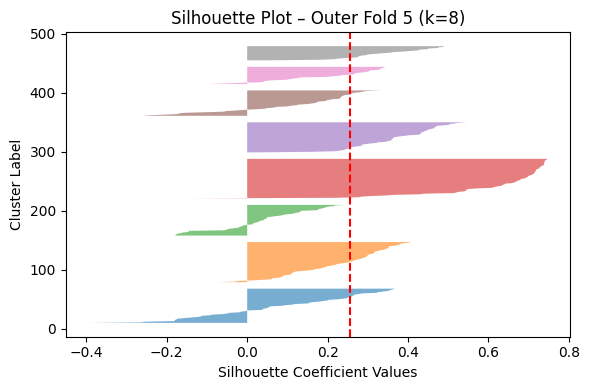


Silhouette Score mean over outer folds: 0.25
Silhouette Score std across outer folds: 0.0
Best k mean over outer folds: 8.6
Best k std over outer folds: 0.8


In [6]:
# Number of clusters in K-Means
k_list = range(3, 20)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store silhouette scores and best k:s
outer_silhouette_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(MNIST_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    MNIST_pixels_train = MNIST_pixels_PCA[outer_train_index]
    MNIST_pixels_test = MNIST_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores scores for each k
    k_metrics = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
        inner_k_fold.split(MNIST_pixels_train):

        # Divide into test and train data
        inner_train = MNIST_pixels_train[inner_train_index]
        inner_val = MNIST_pixels_train[inner_val_index]

        # Perform Agglomerative Clustering for each k
        for k in k_list:

            clustering = AgglomerativeClustering(n_clusters=k)
            cluster_labels = clustering.fit_predict(inner_val)
            sil_score = silhouette_score(inner_val, cluster_labels)
            k_metrics[k].append(sil_score)

    # Calculate average silhouette scores for each k
    avg_scores = {k: np.mean(scores) for k, scores in k_metrics.items()}

    # Calculate best k
    best_k = max(avg_scores, key=avg_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate silluates on test data
    final_clustering = AgglomerativeClustering(n_clusters=best_k)
    final_labels = final_clustering.fit_predict(MNIST_pixels_test)
    outer_sil = silhouette_score(MNIST_pixels_test, final_labels)
    outer_silhouette_scores.append(outer_sil)
    print("Mean silhouette score: " + str(round(outer_sil, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels = MNIST_labels[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels,  # predicted clusters
        true_labels,   # true MNIST labels
        rownames=['Cluster'], colnames=['True Label']
    )

    print("Confusion matrix:")
    print(cluster_label_matrix)

    # GENERATED WITH CHATGPT
    # Compute silhouette values
    sample_silhouette_values = silhouette_samples(MNIST_pixels_test, final_labels)

    # Create silhouette plot
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for cluster in range(best_k):
        ith_cluster_silhouette_values = sample_silhouette_values[final_labels == cluster]
        ith_cluster_silhouette_values.sort()

        size_cluster = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            alpha=0.6
        )
        y_lower = y_upper + 10  # Space between clusters

    plt.title(f'Silhouette Plot – Outer Fold {i + 1} (k={best_k})')
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.axvline(x=outer_sil, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()


# Calculate final results and print
mean_outer_silhouette = np.mean(outer_silhouette_scores)
std_outer_silhouette = np.std(outer_silhouette_scores)
mean_outer_k = np.mean(best_k_list)
std_outer_k = np.std(best_k_list)

print("\nSilhouette Score mean over outer folds: " 
      + str(round(mean_outer_silhouette, 2)))
print("Silhouette Score std across outer folds: " 
      + str(round(std_outer_silhouette, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_outer_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_outer_k, 2)))

## Cats and Dogs: K-Means tuning with silhouette score


Outer fold: 1
Best k: 2
Mean silhouette score: 0.2
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             8    8
1             8   16


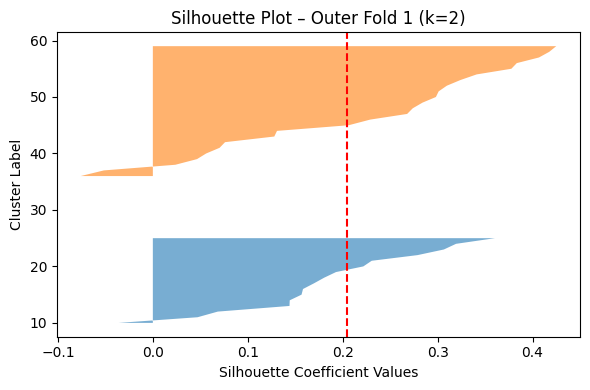


Outer fold: 2
Best k: 2
Mean silhouette score: 0.3
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            11   10
1            10    9


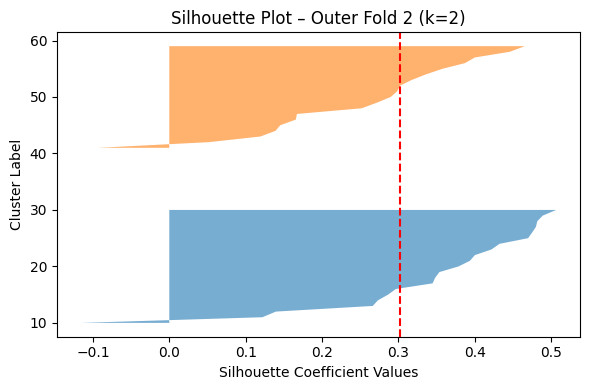


Outer fold: 3
Best k: 2
Mean silhouette score: 0.31
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             9   10
1            12    9


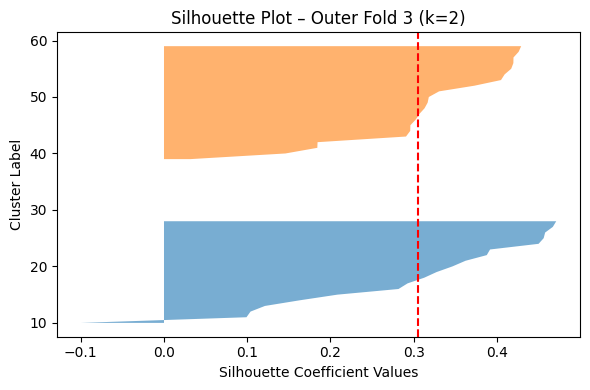


Outer fold: 4
Best k: 2
Mean silhouette score: 0.21
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            13    6
1            10   10


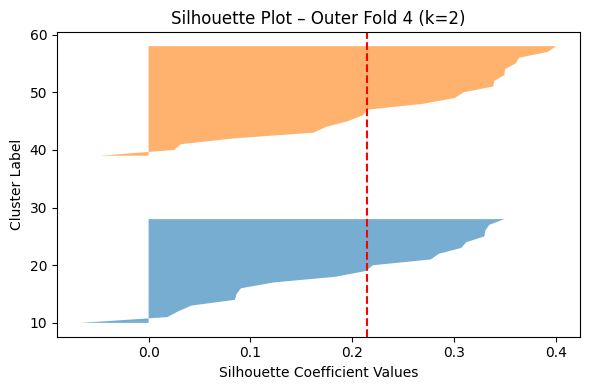


Outer fold: 5
Best k: 2
Mean silhouette score: 0.2
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             9    8
1             9   13


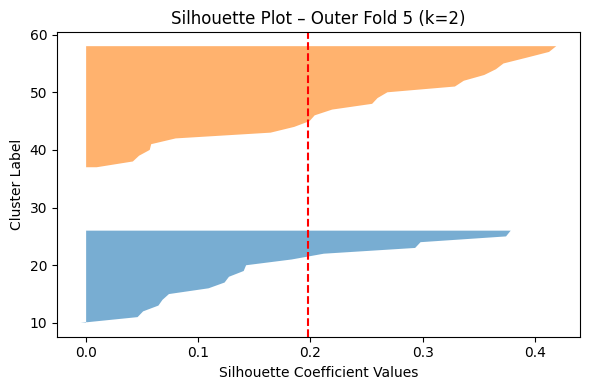


Silhouette Score mean over outer folds: 0.24
Silhouette Score std across outer folds: 0.05
Best k mean over outer folds: 2.0
Best k std over outer folds: 0.0


In [7]:
# Number of clusters in K-Means
k_list = range(2, 10)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store silhouette scores and best k:s
outer_silhouette_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(CATSDOGS_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    CATSDOGS_pixels_train = CATSDOGS_pixels_PCA[outer_train_index]
    CATSDOGS_pixels_test = CATSDOGS_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores scores for each k
    k_metrics = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
        inner_k_fold.split(CATSDOGS_pixels_train):

        # Divide into test and train data
        inner_train = CATSDOGS_pixels_train[inner_train_index]
        inner_val = CATSDOGS_pixels_train[inner_val_index]

        # Perform K-Means clustering for each k
        for k in k_list:

            # K-Means 
            kmeans = KMeans(
                n_clusters=k, init='k-means++', n_init='auto'
            )
            kmeans.fit(inner_train)

            cluster_labels = kmeans.predict(inner_val)
            sil_score = silhouette_score(inner_val, cluster_labels)
            k_metrics[k].append(sil_score)

    # Calculate average silhouette scores for each k
    avg_scores = {k: np.mean(scores) for k, scores in k_metrics.items()}

    # Calculate best k
    best_k = max(avg_scores, key=avg_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate silluates on test data
    final_kmeans = KMeans(
        n_clusters=best_k, init='k-means++', n_init='auto'
    )
    final_kmeans.fit(CATSDOGS_pixels_train)
    final_labels = final_kmeans.predict(CATSDOGS_pixels_test)
    outer_sil = silhouette_score(CATSDOGS_pixels_test, final_labels)
    outer_silhouette_scores.append(outer_sil)
    print("Mean silhouette score: " + str(round(outer_sil, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels =  np.array(CATSDOGS_labels)[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels,  # predicted clusters
        true_labels,   # true MNIST labels
        rownames=['Cluster'], colnames=['True Label']
    )

    print("Confusion matrix:")
    print(cluster_label_matrix)

    # GENERATED WITH CHATGPT
    # Compute silhouette values
    sample_silhouette_values = silhouette_samples(CATSDOGS_pixels_test, final_labels)

    # Create silhouette plot
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for cluster in range(best_k):
        ith_cluster_silhouette_values = sample_silhouette_values[final_labels == cluster]
        ith_cluster_silhouette_values.sort()

        size_cluster = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            alpha=0.6
        )
        y_lower = y_upper + 10  # Space between clusters

    plt.title(f'Silhouette Plot – Outer Fold {i + 1} (k={best_k})')
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.axvline(x=outer_sil, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()


# Calculate final results and print
mean_outer_silhouette = np.mean(outer_silhouette_scores)
std_outer_silhouette = np.std(outer_silhouette_scores)
mean_outer_k = np.mean(best_k_list)
std_outer_k = np.std(best_k_list)

print("\nSilhouette Score mean over outer folds: " 
      + str(round(mean_outer_silhouette, 2)))
print("Silhouette Score std across outer folds: " 
      + str(round(std_outer_silhouette, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_outer_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_outer_k, 2)))

## Cats and Dogs: GMM tuning with BIC

In [8]:
# Number of clusters in GMM
k_list = range(2, 10)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store bic scores and best k:s
outer_bic_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(CATSDOGS_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    CATSDOGS_pixels_train = CATSDOGS_pixels_PCA[outer_train_index]
    CATSDOGS_pixels_test = CATSDOGS_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores for each k
    bic_scores_per_k = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
            inner_k_fold.split(CATSDOGS_pixels_train):
        
        # Divide into test and train data
        inner_train = CATSDOGS_pixels_train[inner_train_index]
        inner_val = CATSDOGS_pixels_train[inner_val_index]

        # Perform GMM clustering for each k
        for k in k_list:
            gmm = GaussianMixture(n_components=k, covariance_type='full')
            gmm.fit(inner_train)
            bic = gmm.bic(inner_val)
            bic_scores_per_k[k].append(bic)

    # Calculate average BIC scores for each k
    avg_bic_scores = {k: np.mean(scores) for k, scores in bic_scores_per_k.items()}

    # Calculate best k
    best_k = min(avg_bic_scores, key=avg_bic_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate BIC on test data
    final_gmm = GaussianMixture(
        n_components=best_k, covariance_type='full'
    )
    final_gmm.fit(CATSDOGS_pixels_train)
    final_labels = final_gmm.predict(CATSDOGS_pixels_test)
    outer_sil = final_gmm.bic(CATSDOGS_pixels_test)
    outer_bic_scores.append(outer_sil)
    print("Bic score: " + str(round(outer_sil, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels = np.array(CATSDOGS_labels)[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels, true_labels,
        rownames=['Cluster'], colnames=['True Label']
    )
    print("Confusion matrix:")
    print(cluster_label_matrix)

# Calculate final results and print
mean_outer_bic = np.mean(outer_bic_scores)
std_outer_bic = np.std(outer_bic_scores)
mean_best_k = np.mean(best_k_list)
std_best_k = np.std(best_k_list)

print("\nBIC mean over outer folds: " 
      + str(round(mean_outer_bic, 2)))
print("BIC std across outer folds: " 
      + str(round(std_outer_bic, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_best_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_best_k, 2)))



Outer fold: 1
Best k: 2
Bic score: 1124.11
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            12    4
1             4   20

Outer fold: 2
Best k: 2
Bic score: 1127.59
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             4    9
1            17   10

Outer fold: 3
Best k: 2
Bic score: 1121.49
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            11   13
1            10    6

Outer fold: 4
Best k: 2
Bic score: 1099.9
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            19    3
1             4   13

Outer fold: 5
Best k: 2
Bic score: 1046.67
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             3   11
1            15   10

BIC mean over outer folds: 1103.95
BIC std across outer folds: 30.23
Best k mean over outer folds: 2.0
Best k std over outer folds: 0.0


## Cats and Dogs: Agglomerative Clustering tuning with silhouette score


Outer fold: 1
Best k: 6
Mean silhouette score: 0.23
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             6    1
1             3    9
2             0    5
3             5    4
4             1    0
5             1    5


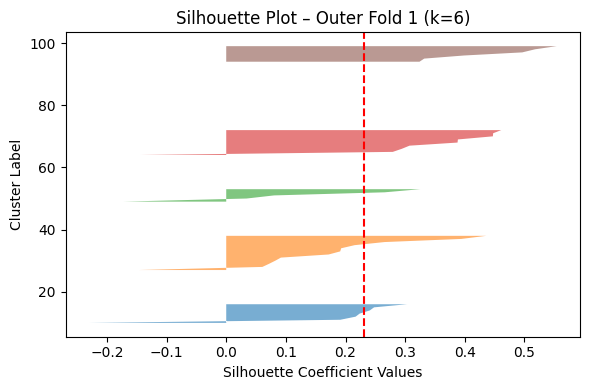


Outer fold: 2
Best k: 9
Mean silhouette score: 0.3
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             3    3
1             5    6
2             1    2
3             1    3
4             2    2
5             2    2
6             5    0
7             2    0
8             0    1


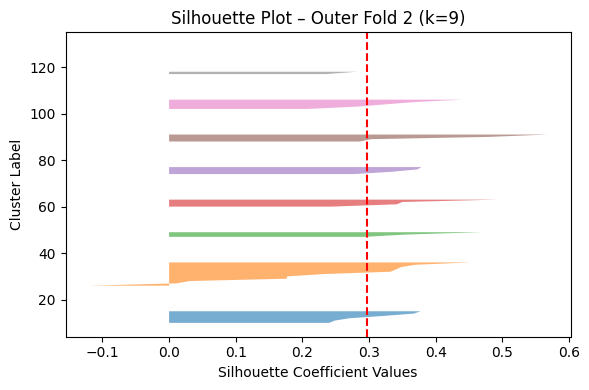


Outer fold: 3
Best k: 9
Mean silhouette score: 0.22
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             3    3
1             4    1
2             3    4
3             2    4
4             1    0
5             1    3
6             1    3
7             4    1
8             2    0


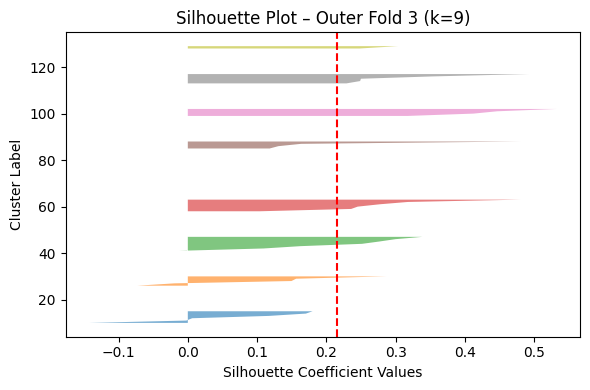


Outer fold: 4
Best k: 2
Mean silhouette score: 0.24
Confusion matrix:
True Label  Cat  Dog
Cluster             
0            10   15
1            13    1


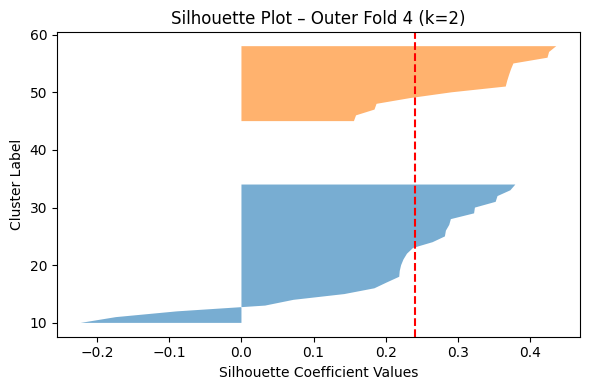


Outer fold: 5
Best k: 5
Mean silhouette score: 0.25
Confusion matrix:
True Label  Cat  Dog
Cluster             
0             6   10
1             0    7
2             9    0
3             1    2
4             2    2


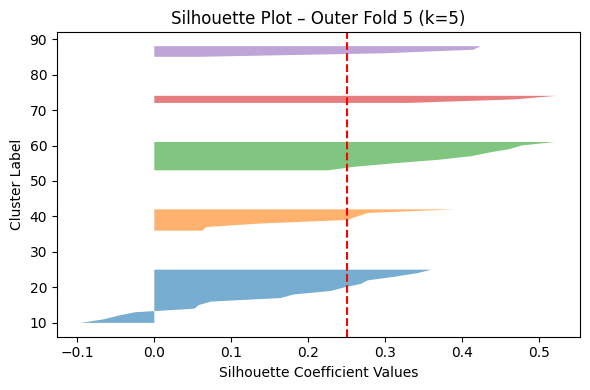


Silhouette Score mean over outer folds: 0.25
Silhouette Score std across outer folds: 0.03
Best k mean over outer folds: 6.2
Best k std over outer folds: 2.64


In [9]:
# Number of clusters in K-Means
k_list = range(2, 10)

# Cross-validation parameters (double cross validation)
number_of_inner_k_folds = 5
number_of_outer_k_folds = 5

# Outer fold - Determines stability
outer_k_fold = KFold(
    n_splits=number_of_outer_k_folds, shuffle=True, random_state=123
)

# Store silhouette scores and best k:s
outer_silhouette_scores = []
best_k_list = []

for i, (outer_train_index, outer_test_index) in enumerate(
        outer_k_fold.split(CATSDOGS_pixels_PCA)):
    
    print("\nOuter fold: " + str(i + 1))

    # Divide into test and train data
    CATSDOGS_pixels_train = CATSDOGS_pixels_PCA[outer_train_index]
    CATSDOGS_pixels_test = CATSDOGS_pixels_PCA[outer_test_index]

    # Inner fold - For tuning (number of clusters)
    inner_k_fold = KFold(
        n_splits=number_of_inner_k_folds, shuffle=True, random_state=i
    )

    # Dictionary for storing scores scores for each k
    k_metrics = {k: [] for k in k_list}

    for inner_train_index, inner_val_index in \
        inner_k_fold.split(CATSDOGS_pixels_train):

        # Divide into test and train data
        inner_train = CATSDOGS_pixels_train[inner_train_index]
        inner_val = CATSDOGS_pixels_train[inner_val_index]

        # Perform Agglomerative clustering for each k
        for k in k_list:

            clustering = AgglomerativeClustering(
                n_clusters=k, linkage='ward'
            )
            cluster_labels = clustering.fit_predict(inner_val)
            sil_score = silhouette_score(inner_val, cluster_labels)
            k_metrics[k].append(sil_score)
    
    # Calculate average silhouette scores for each k
    avg_scores = {k: np.mean(scores) for k, scores in k_metrics.items()}

    # Calculate best k
    best_k = max(avg_scores, key=avg_scores.get)
    best_k_list.append(best_k)
    print("Best k: " + str(best_k))

    # Calculate silhouetes on test data
    final_clustering = AgglomerativeClustering(
        n_clusters=best_k, linkage='ward'
    )
    final_labels = final_clustering.fit_predict(CATSDOGS_pixels_test) 
    outer_sil = silhouette_score(CATSDOGS_pixels_test, final_labels)
    outer_silhouette_scores.append(outer_sil)
    print("Mean silhouette score: " + str(round(outer_sil, 2)))

    # GENERATED WITH CHATGPT
    # Get true labels for the outer test set
    true_labels =  np.array(CATSDOGS_labels)[outer_test_index]

    # Create a cross-tabulation (cluster vs true label)
    cluster_label_matrix = pd.crosstab(
        final_labels,  # predicted clusters
        true_labels,   # true CATSDOGS labels
        rownames=['Cluster'], colnames=['True Label']
    )

    print("Confusion matrix:")
    print(cluster_label_matrix)

    # GENERATED WITH CHATGPT
    # Compute silhouette values
    sample_silhouette_values = silhouette_samples(CATSDOGS_pixels_test, final_labels)

    # Create silhouette plot
    plt.figure(figsize=(6, 4))
    y_lower = 10
    for cluster in range(best_k):
        ith_cluster_silhouette_values = sample_silhouette_values[final_labels == cluster]
        ith_cluster_silhouette_values.sort()

        size_cluster = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster

        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0, ith_cluster_silhouette_values,
            alpha=0.6
        )
        y_lower = y_upper + 10  # Space between clusters

    plt.title(f'Silhouette Plot – Outer Fold {i + 1} (k={best_k})')
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster Label")
    plt.axvline(x=outer_sil, color="red", linestyle="--")
    plt.tight_layout()
    plt.show()


# Calculate final results and print
mean_outer_silhouette = np.mean(outer_silhouette_scores)
std_outer_silhouette = np.std(outer_silhouette_scores)
mean_outer_k = np.mean(best_k_list)
std_outer_k = np.std(best_k_list)

print("\nSilhouette Score mean over outer folds: " 
      + str(round(mean_outer_silhouette, 2)))
print("Silhouette Score std across outer folds: " 
      + str(round(std_outer_silhouette, 2)))
print("Best k mean over outer folds: " 
      + str(round(mean_outer_k, 2)))
print("Best k std over outer folds: " 
      + str(round(std_outer_k, 2)))